In [1]:
# import datetime
# import numpy as np
# # import matplotlib.pyplot as plt
# # from scipy.signal import welch
# # from scipy.signal.windows.windows import hamming
import initialize

In [2]:
class Result(object):
    def __init__(self, settings):
        self._settings = settings
        self._results = None
        self._channels = None

    @property
    def settings(self):
        return self._settings

    @property
    def channels(self):
        assert isinstance(self._channels, np.recarray)
        return self._channels

    @property
    def results(self):
        assert isinstance(self._results, np.recarray)
        return self._results

    @results.setter
    def results(self, records):
        assert isinstance(records, np.recarray)
        self._results = records

    def plot(self):
        pass

In [3]:
class TruePosition(object):
    def __init__(self):
        self._E = None
        self._N = None
        self._U = None

    @property
    def E(self):
        return self._E

    @E.setter
    def E(self, e):
        self._E = e

    @property
    def N(self):
        return self._N

    @N.setter
    def N(self, n):
        self._N = n

    @property
    def U(self):
        return self._U

    @U.setter
    def U(self, u):
        self._U = u

In [4]:
class Settings(object):
    
    def __init__(self):
        self.msToProcess = 37000.0
        self.numberOfChannels = 8
        self.skipNumberOfBytes = 0
        # self.fileName = '/Users/yangsu/Downloads/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin'
        self.fileName = 'C:/Repository/SoftGNSS-python/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin'
        self.dataType = 'int8'
        self.IF = 9548000.0
        self.samplingFreq = 38192000.0
        self.codeFreqBasis = 1023000.0
        self.codeLength = 1023
        self.skipAcquisition = False
        self.acqSatelliteList = range(1, 33)
        self.acqSearchBand = 14.0
        self.acqThreshold = 2.5
        self.dllDampingRatio = 0.7
        self.dllNoiseBandwidth = 2.0
        self.dllCorrelatorSpacing = 0.5
        self.pllDampingRatio = 0.7
        self.pllNoiseBandwidth = 25.0
        self.navSolPeriod = 500.0
        self.elevationMask = 10.0
        self.useTropCorr = True
        self.truePosition = TruePosition()
        self.plotTracking = True
        self._c = 299792458.0
        self._startOffset = 68.802
        
    @property
    def c(self):
        return self._c

    @property
    def startOffset(self):
        return self._startOffset

    @property
    def samplesPerCode(self):
        # return np.long(np.round(self.samplingFreq / (self.codeFreqBasis / self.codeLength)))
        return int(np.round(self.samplingFreq / (self.codeFreqBasis / self.codeLength)))


    def makeCaTable(self):
        samplesPerCode = self.samplesPerCode
        caCodesTable = np.zeros((32, samplesPerCode))
        ts = 1.0 / self.samplingFreq
        tc = 1.0 / self.codeFreqBasis
        for PRN in range(32):
            caCode = self.generateCAcode(PRN)
            codeValueIndex = np.ceil(ts * np.arange(1, samplesPerCode + 1) / tc) - 1
            codeValueIndex = np.longlong(codeValueIndex)
            codeValueIndex[-1] = 1022
            caCodesTable[PRN] = caCode[codeValueIndex]
        return caCodesTable

    def generateCAcode(self, prn):
        # generateCAcode.m generates one of the 32 GPS satellite C/A codes.

        # CAcode = generateCAcode(PRN)

        #   Inputs:
        #       PRN         - PRN number of the sequence.

        #   Outputs:
        #       CAcode      - a vector containing the desired C/A code sequence
        #                   (chips).

        # --- Make the code shift array. The shift depends on the PRN number -------
        # The g2s vector holds the appropriate shift of the g2 code to generate
        # the C/A code (ex. for SV#19 - use a G2 shift of g2s(19) = 471)

        assert prn in range(0, 32)
        g2s = [5, 6, 7, 8, 17, 18, 139, 140, 141, 251,
               252, 254, 255, 256, 257, 258, 469, 470, 471, 472,
               473, 474, 509, 512, 513, 514, 515, 516, 859, 860,
               861, 862,
               145, 175, 52, 21, 237, 235, 886, 657, 634, 762, 355, 1012, 176, 603, 130, 359, 595, 68, 386]

        # --- Pick right shift for the given PRN number ----------------------------
        g2shift = g2s[prn]

        # --- Generate G1 code -----------------------------------------------------

        # --- Initialize g1 output to speed up the function ---
        g1 = np.zeros(1023)

        # --- Load shift register ---
        reg = -1 * np.ones(10)

        # --- Generate all G1 signal chips based on the G1 feedback polynomial -----
        for i in range(1023):
            g1[i] = reg[-1]

            saveBit = reg[2] * reg[9]

            reg[1:] = reg[:-1]

            reg[0] = saveBit

        # --- Generate G2 code -----------------------------------------------------

        # --- Initialize g2 output to speed up the function ---
        g2 = np.zeros(1023)

        # --- Load shift register ---
        reg = -1 * np.ones(10)

        # --- Generate all G2 signal chips based on the G2 feedback polynomial -----
        for i in range(1023):
            g2[i] = reg[-1]

            saveBit = reg[1] * reg[2] * reg[5] * reg[7] * reg[8] * reg[9]

            reg[1:] = reg[:-1]

            reg[0] = saveBit

        # --- Shift G2 code --------------------------------------------------------
        # The idea: g2 = concatenate[ g2_right_part, g2_left_part ];
        g2 = np.r_[g2[1023 - g2shift:], g2[:1023 - g2shift]]

        # --- Form single sample C/A code by multiplying G1 and G2 -----------------
        CAcode = -g1 * g2
        return CAcode

    @staticmethod
    def calcLoopCoef(LBW, zeta, k):
        Wn = LBW * 8.0 * zeta / (4.0 * zeta ** 2 + 1)
        tau1 = k / (Wn * Wn)
        tau2 = 2.0 * zeta / Wn

        return tau1, tau2

    def probeData(self, fileNameStr=None):
        
        import matplotlib.pyplot as plt
        from scipy.signal import welch
        from scipy.signal.windows.windows import hamming
        
        if fileNameStr is None:
            fileNameStr = self.fileName
        if not isinstance(fileNameStr, str):
            raise TypeError('File name must be a string')
        settings = self  
        try:
            with open(fileNameStr, 'rb') as fid:
                fid.seek(settings.skipNumberOfBytes, 0)
                samplesPerCode = settings.samplesPerCode
                try:
                    data = np.fromfile(fid, settings.dataType, 10 * samplesPerCode)
                except IOError:
                # The file is too short
                    print('Could not read enough data from the data file.')
                # --- Initialization ---------------------------------------------------
                # plt.figure(100)
                # plt.clf()
                # timeScale = np.arange(0, 0.005, 1 / settings.samplingFreq)
                # plt.subplot(2, 2, 1)
                # plt.plot(1000 * timeScale[1:samplesPerCode / 50], data[1:samplesPerCode / 50])
                # plt.axis('tight')
                # plt.grid()
                # plt.title('Time domain plot')
                # plt.xlabel('Time (ms)')
                # plt.ylabel('Amplitude')
                # plt.subplot(2, 2, 2)
                # f, Pxx = welch(data - np.mean(data), settings.samplingFreq / 1000000.0,
                #                hamming(16384, False),
                #                16384,
                #                1024,
                #                16384)
                # plt.semilogy(f, Pxx)
                # plt.axis('tight')
                # plt.grid()
                # plt.title('Frequency domain plot')
                # plt.xlabel('Frequency (MHz)')
                # plt.ylabel('Magnitude')
                # plt.show()
                # plt.subplot(2, 2, 3.5)
                # plt.hist(data, np.arange(- 128, 128))
                # dmax = np.max(np.abs(data)) + 1

                # plt.axis('tight')
                # adata = plt.axis()

                # plt.axis([-dmax, dmax, adata[2], adata[3]])
                # plt.grid('on')
                # plt.title('Histogram')
                # plt.xlabel('Bin')
                # plt.ylabel('Number in bin')
        #      # === Error while opening the data file ================================
        except IOError as e:
            print('Unable to read file "%s": %s' % (fileNameStr, e))

    def postProcessing(self, fileNameStr=None):
        import acquisition
        import postNavigation
        import tracking
        print ('Starting processing...')
        settings = self
        if not fileNameStr:
            fileNameStr = settings.fileName
        if not isinstance(fileNameStr, str):
            raise TypeError('File name must be a string')
        try:
            with open(fileNameStr, 'rb') as fid:

                # If success, then process the data
                # Move the starting point of processing. Can be used to start the
                # signal processing at any point in the data record (e.g. good for long
                # records or for signal processing in blocks).
                fid.seek(settings.skipNumberOfBytes, 0)
                # Acquisition ============================================================
                # Do acquisition if it is not disabled in settings or if the variable
                # acqResults does not exist.
                if not settings.skipAcquisition:  # or 'acqResults' not in globals():
                    # Find number of samples per spreading code
                    samplesPerCode = settings.samplesPerCode

                    # frequency estimation
                    data = np.fromfile(fid, settings.dataType, 11 * samplesPerCode)

                    # print '   Acquiring satellites...'
                    acqResults = acquisition.AcquisitionResult(settings)
                    acqResults.acquire(data)
                    acqResults.plot()
                # Initialize channels and prepare for the run ============================
                # Start further processing only if a GNSS signal was acquired (the
                # field FREQUENCY will be set to 0 for all not acquired signals)
                if np.any(acqResults.carrFreq):
                    acqResults.preRun()
                    acqResults.showChannelStatus()
                else:
                    # No satellites to track, exit
                    # print 'No GNSS signals detected, signal processing finished.'
                    trackResults = None

                # Track the signal =======================================================
                startTime = datetime.datetime.now()

                # print '   Tracking started at %s' % startTime.strftime('%X')
                trackResults = tracking.TrackingResult(acqResults)
                try:
                    trackResults.results = np.load('trackingResults_python.npy')
                except IOError:
                    trackResults.track(fid)
                    np.save('trackingResults_python', trackResults.results)

                print('   Tracking is over (elapsed time %s s)' % (datetime.datetime.now() - startTime).total_seconds())
                # Auto save the acquisition & tracking results to save time.
                print('   Saving Acquisition & Tracking results to storage')
                # Calculate navigation solutions =========================================
                print('   Calculating navigation solutions...')
                navResults = postNavigation.NavigationResult(trackResults)
                navResults.postNavigate()

                print('   Processing is complete for this data block')
                # Plot all results ===================================================
                print('   Plotting results...')
                # TODO turn off tracking plots for now
                if not settings.plotTracking:
                    trackResults.plot()
                navResults.plot()
                print('Post processing of the signal is over.')
        except IOError as e:
            # Error while opening the data file.
            print('Unable to read file "%s": %s.' % (settings.fileName, e))


In [2]:
# settings = Settings()
settings = initialize.Settings()

Probing data "/Users/yangsu/Downloads/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin"...
Unable to read file "/Users/yangsu/Downloads/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin": [Errno 2] No such file or directory: '/Users/yangsu/Downloads/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin'


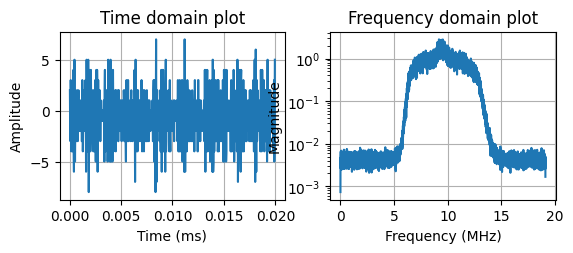

ValueError: num must be an integer with 1 <= num <= 4, not 3.5

<Figure size 640x480 with 0 Axes>

In [3]:
# Generate plot of raw data and ask if ready to start processing =========
try:
    print('Probing data "%s"...' % settings.fileName)
    settings.probeData()
    # settings.probeData('/Users/yangsu/Downloads/GNSS_signal_records/GPS_and_GIOVE_A-NN-fs16_3676-if4_1304.bin')
    settings.probeData('C:/Repository/SoftGNSS-python/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin')
finally:
    pass

In [4]:
print('  Raw IF data plotted ')
print('  (run setSettings or change settings in "initialize.py" to reconfigure)')
print(' ')
gnssStart = True

  Raw IF data plotted 
  (run setSettings or change settings in "initialize.py" to reconfigure)
 


In [5]:
if gnssStart:
    print(' ')
    settings.postProcessing()

 
Importing functions from ./geoFunctions/
Starting processing...
Unable to read file "/Users/yangsu/Downloads/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin": [Errno 2] No such file or directory: '/Users/yangsu/Downloads/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin'.
